In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/pheme/pheme-dataset.csv'
# test_path = '/content/drive/MyDrive/Fakenews/test.csv'

df = pd.read_csv(path)
df.head(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,text,target
0,0,"Breaking: At least 10 dead, 5 injured after tO...",1
1,1,France: 10 people dead after shooting at HQ of...,1
2,2,Ten killed in shooting at headquarters of Fren...,1
3,3,BREAKING: 10 dead in shooting at headquarters ...,1
4,4,Reuters: 10 people shot dead at headquarters o...,1


In [2]:
print(df.shape)
df.isna().sum()

(1705, 3)


Unnamed: 0    0
text          0
target        0
dtype: int64

,text,target
0,BREAKING: Peter Mansbridge now reporting one s...,1
1,"And I'm now officially done with @Uber, which ...",1
2,BREAKING UPDATE: Gunman demands to speak to #A...,1
3,BREAKING: Distress call linked with #Germanwin...,0
4,Leafs-Sens game postponed after shootings on P...,1
...,...,...
1700,"UPDATED: Prince not playing Massey Hall, Live ...",0
1701,Hostage taker in Sydney cafe demands 2 things:...,1
1702,The NHL announces tonight's game between the #...,1
1703,Hostage falls into policeman’s arms after bein...,1


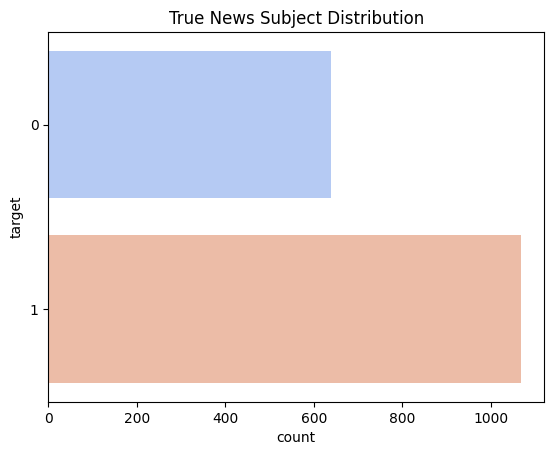

In [3]:
from sklearn.utils import shuffle

df = df[['text','target']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="target", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1705 non-null   object
 1   target  1705 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.8+ KB


In [5]:
df.drop_duplicates(subset=['text'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1699 entries, 0 to 1704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1699 non-null   object
 1   target  1699 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.8+ KB


In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['text'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [8]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 1699
Max length of the titles: 18
Mean length of the titles: 10.334902884049441
Median length of the titles: 10.0


In [9]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(list_of_words)

sequences = tokenizer.texts_to_sequences(list_of_words)
padded_df = pad_sequences(sequences,maxlen = max_len, padding = 'pre', truncating = 'post')


# **LSTM**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
## Creating model Using LSTM

embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(Dropout(0.3))
model.add(Conv1D(32,5,activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32,5,activation='relu'))
model.add(MaxPool1D())
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['target'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

In [12]:
# upsampling and shuffle
import numpy as np
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)
x_val, y_val = ros.fit_resample(x_val, y_val)
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_val, y_val = shuffle(x_val, y_val, random_state=42)

Epoch 1/3
24/24 [==============================] - 26s 489ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6925 - val_accuracy: 0.6143
Epoch 2/3
24/24 [==============================] - 3s 107ms/step - loss: 0.6840 - accuracy: 0.6727 - val_loss: 0.6663 - val_accuracy: 0.7190
Epoch 3/3
24/24 [==============================] - 3s 130ms/step - loss: 0.4915 - accuracy: 0.8353 - val_loss: 0.4048 - val_accuracy: 0.7762


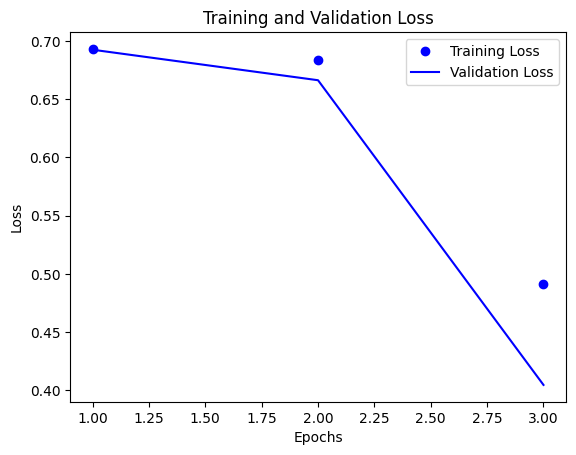

In [13]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 3)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

11/11 [==============================] - 1s 8ms/step
CNN-BiLSTM Model Accuracy :  0.8235294117647058
Precision :  0.8564593301435407
Recall :  0.8564593301435407
F1 :  0.8564593301435407
G-mean: 0.8126029815864496
Training time:  49.67081904411316
Inference time:  0.9658851623535156
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       131
           1       0.86      0.86      0.86       209

    accuracy                           0.82       340
   macro avg       0.81      0.81      0.81       340
weighted avg       0.82      0.82      0.82       340



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


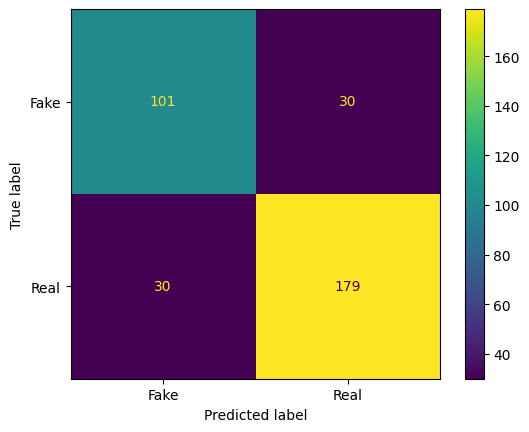

In [14]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("CNN-BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()